In [1]:
import os
import shutil
import unittest
import importlib

import numpy as np
import torch
import matplotlib.pyplot as plt

from src.ai.base_net import ArchitectureConfig
from src.ai.evaluator import Evaluator, EvaluatorConfig
from src.core.utils import get_to_root_dir, get_filename_without_extension
from src.ai.architectures import *  # Do not remove
from src.data.data_loader import DataLoaderConfig, DataLoader

os.environ['DATADIR'] = os.environ['HOME']+'/code/imitation-learning-codebase/experimental_data'
output_path = "offline_model_evaluation"
architecture_base_config = {
    "output_path": output_path,
    "architecture": "dronet",
    "initialisation_type": 'xavier',
}
network = eval(architecture_base_config['architecture']).Net(
            config=ArchitectureConfig().create(config_dict=architecture_base_config)
        )

dronet - INFO - Started.


In [2]:
evaluator_base_config = {
    "output_path": output_path,
    "data_loader_config": {
        "input_size": [1, 200, 200],
        "hdf5_files": ['line_world_data/real/validation.hdf5']
    },
}
evaluator = Evaluator(config=EvaluatorConfig().create(config_dict=evaluator_base_config),
                      network=network)

data_loader - INFO - Started.
data_loader - INFO - Loaded 1186 from ['/Users/kelchtermans/code/imitation-learning-codebase/experimental_data/line_world_data/real/validation.hdf5']


In [3]:
dataset = evaluator.data_loader.get_dataset()
predictions = network.forward(dataset.observations, train=False)
error =  predictions - torch.stack(dataset.actions)

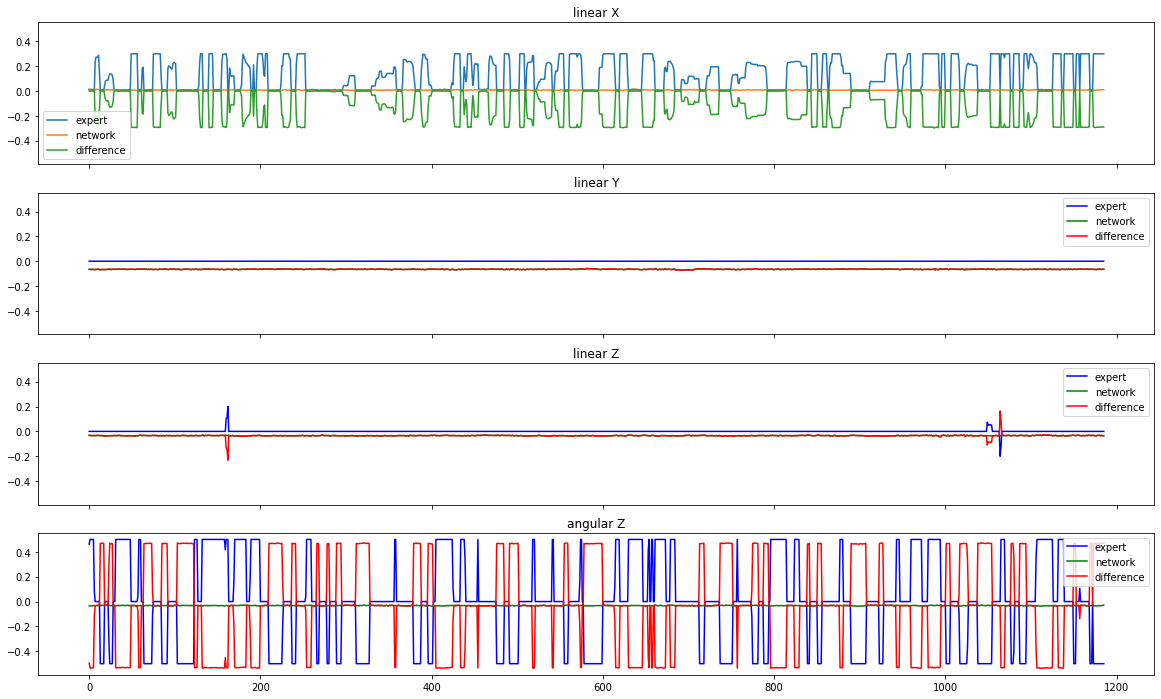

In [51]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(20, 3*4))

ax1.set_title('linear X')
ax1.plot([a[0] for a in dataset.actions], 'C0', label='expert')
ax1.plot([p[0] for p in predictions], 'C1', label='network')
ax1.plot([e[0] for e in error], 'C2', label='difference')
ax1.legend()

ax2.set_title('linear Y')
ax2.plot([a[1] for a in dataset.actions], 'b', label='expert')
ax2.plot([p[1] for p in predictions], 'g', label='network')
ax2.plot([e[1] for e in error], 'r', label='difference')
ax2.legend()

ax3.set_title('linear Z')
ax3.plot([a[2] for a in dataset.actions], 'b', label='expert')
ax3.plot([p[2] for p in predictions], 'g', label='network')
ax3.plot([e[2] for e in error], 'r', label='difference')
ax3.legend()

ax4.set_title('angular Z')
ax4.plot([a[-1] for a in dataset.actions], 'b', label='expert')
ax4.plot([p[-1] for p in predictions], 'g', label='network')
ax4.plot([e[-1] for e in error], 'r', label='difference')
ax4.legend()

plt.show()

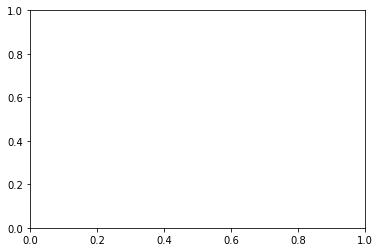

In [65]:
import cv2 
import os
import subprocess
import glob

folder = 'out'
os.makedirs(folder, exist_ok=True)

for image_index in range(1):
    plt.figure()
    border_width = 100
    image = dataset.observations[image_index].squeeze()
    action = dataset.actions[image_index]
    prediction = predictions[image_index].detach().numpy()

    image = np.stack((image,)*3, axis=-1)
    border = np.ones((image.shape[0], border_width, 3), dtype=image.dtype)
    image = np.concatenate([border, image], axis=1)

    colors = [(0.8, 0.1, 0.5), (0.1, 0.8, 0.1)]
    for index, (l, a) in enumerate([('expert', action), ('network', prediction)]):
        forward_speed = 100 * (a[0] + 0.1)
        direction = np.arccos(a[-1])
        origin = (50, int(image.shape[0] / 2))
        steering_point = (int(origin[0] - forward_speed * np.cos(direction)),
                          int(origin[1] - forward_speed * np.sin(direction)))
        image = cv2.arrowedLine(image, origin, steering_point, color=colors[index], thickness=1)
        image = cv2.putText(image, l, (3, origin[1] + 55 + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.45, colors[index],
                            thickness=2)
    image = cv2.circle(image, origin, radius=20, color=(0, 0, 0, 0.3), thickness=1)

    plt.tight_layout()
    plt.axis('off')
    plt.imshow(image)
    plt.savefig(folder + "/file%02d.jpg" % image_index)
    plt.close()
    plt.cla()

os.chdir("out")
subprocess.call([
    'ffmpeg', '-framerate', '8', '-i', 'file%02d.jpg', '-r', '30', '-pix_fmt', 'yuv420p',
    'video_name.mp4'
])
for file_name in glob.glob("*.jpg"):
    os.remove(file_name)
os.chdir('..')

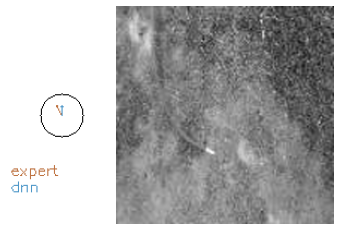

In [71]:
for image_index in range(1):
    plt.figure()
    border_width = 100
    image = dataset.observations[image_index].squeeze()
    action = dataset.actions[image_index]
    prediction = predictions[image_index].detach().numpy()

    image = np.stack((image,)*3, axis=-1)
    border = np.ones((image.shape[0], border_width, 3), dtype=image.dtype)
    image = np.concatenate([border, image], axis=1)

    colors = [(190/255., 114/255., 64/255.), 
              (75/255., 150/255., 200/255.)]
    for index, (l, a) in enumerate([('expert', action), ('dnn', prediction)]):
        forward_speed = 100 * (a[0] + 0.1)
        direction = np.arccos(a[-1])
        origin = (50, int(image.shape[0] / 2))
        steering_point = (int(origin[0] - forward_speed * np.cos(direction)),
                          int(origin[1] - forward_speed * np.sin(direction)))
        image = cv2.arrowedLine(image, origin, steering_point, color=colors[index], thickness=1)
        image = cv2.putText(image, l, (3, origin[1] + 55 + index * 15), cv2.FONT_HERSHEY_SIMPLEX, 0.45, colors[index],
                            thickness=1)
    image = cv2.circle(image, origin, radius=20, color=(0, 0, 0, 0.3), thickness=1)

    plt.tight_layout()
    plt.axis('off')
    plt.imshow(image)

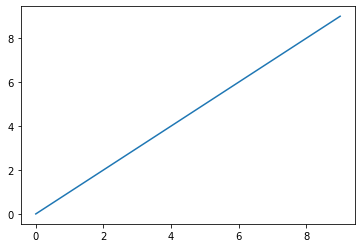

In [69]:
plt.plot(range(10), 'C0')

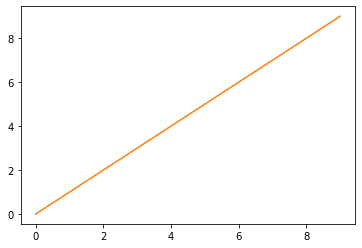

In [70]:
plt.plot(range(10), 'C1')